# Arash Modaresi Rad

## student ID: 114089286

### Collaborate: Amir Kazemzadeh & Ahmad Hojatimalekshah


# CS534 Homework 3

Put your homework in the directory with your name. Please mentionin this file the names of any students with whom you collaborated. If you didn't collaborate with anyone, mark your collaborators as "None." Remember, your goal is to communicate. Full credit will be given only to correct solutions which are described clearly. Convoluted and obtuse descriptions will receive low marks. To complete your homework, you may ONLY consult the following material:

lecture slides course notes you or others took during lecture. the required text (CLRS) websites that may clarify the concepts covered in the material but do not in any way provide complete solutions to the problems. Deadline 04/15/2020

Please provide an answer to the following question:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import train_test_split , StratifiedKFold, KFold, cross_validate, learning_curve, GridSearchCV
from sklearn.svm import SVC

# Question 1 (15 pts)

To classify iris dataset (Iris-Versicolor vs. others) in the best way, you have to create an algorithm able to determine (with the k-fold cross validation) what is the best space transformation (among rbf_kernel, polynomial features, and polynomial kernel) and its hyperparameters. Each transformation has its own parameters rbf_kernel->gamma, polynomial-features-> degree, polynomial_kernel ->(gamma, degree). The performance has to be tested of the entire algorithm with another K-fold cross-validation (please use then trainset, validationset, and testset).

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\statsmodels\datasets\utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


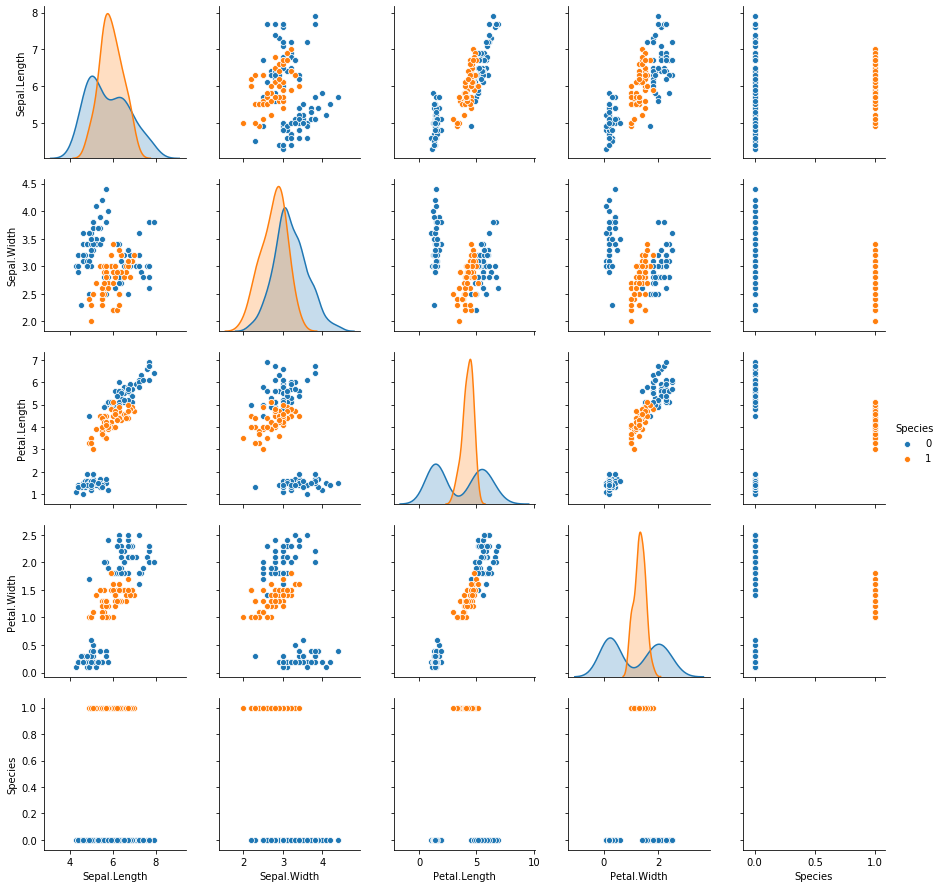

In [3]:
iris = sm.datasets.get_rdataset('iris').data
iris['Species'] = iris['Species'].apply(lambda x: 1  if x == 'versicolor' else 0)
iris_data = iris.drop(labels='Species', axis=1)
iris_target = iris.drop(labels=['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'], axis=1)
data_train, data_test, target_train, target_test = train_test_split(iris_data, iris_target, test_size = 0.2, random_state = 10)
sns.pairplot(data=iris, hue='Species')

In [4]:
iris['Species'].unique()

array([0, 1], dtype=int64)

Standardize the data

In [5]:
class standardizer():
    def __init__(self):
        self.std = 0
    #@property
    #@staticmethod
    def STD(self, data):
        mean = np.mean(data, axis = 0)
        scale = np.std(data, axis = 0)
        self.std = (data - mean) / scale
        return self.std

Setup parameter space:

In [6]:
STDr = standardizer()
target_train = target_train.values
target_test = target_test.values
data_test_std = STDr.STD(data_test).values
data_train = data_train.values

In [7]:
C_count, gamma_count, degree_count = (20, 20 , 4)
space = C_count * gamma_count * degree_count
C = np.linspace(0.001, 1000, C_count)
gamma = np.linspace(0.0001, 1, gamma_count)
degree = np.linspace(1, 4, degree_count)
C_mesh, gamma_mesh, degree_mesh = np.meshgrid(C, gamma, degree)
Parameter_space = np.concatenate((C_mesh.reshape((space, 1)), gamma_mesh.reshape((space, 1)), degree_mesh.reshape((space, 1))), axis = 1)

In [8]:
def Parameter_search(splits, data, target, Parameter_space):
    
    Kfold_model = KFold(n_splits = splits, random_state = 10, shuffle = True)
    indicies = list(Kfold_model.split(data, target))
    Output = pd.DataFrame()
    
    for i in range(len(Parameter_space)):
        # a model for transforming features
        poly_feature_model = PolynomialFeatures(degree = (Parameter_space[i][2]).astype(int)) 
        
        # classifiers.
        model_poly_transformed = SVC(C=Parameter_space[i][0], gamma=Parameter_space[i][1])
        model_rbf = SVC(kernel='rbf', C=Parameter_space[i][0], gamma=Parameter_space[i][1])
        model_poly = SVC(kernel='poly', C=Parameter_space[i][0], gamma=Parameter_space[i][1], degree = Parameter_space[i][2])
        
        # Kfold loops
        for j in range(0, splits):

            # train and validatie
            data_train = data[indicies[j][0]]
            data_valid = data[indicies[j][1]]
            data_trans_train = poly_feature_model.fit_transform(data[indicies[j][0]])
            data_trans_valid = poly_feature_model.fit_transform(data[indicies[j][1]])
            target_train = target[indicies[j][0]]
            target_valid = target[indicies[j][1]]

            # standardize the train and validation data
            sc = StandardScaler()
            data_std_train = sc.fit_transform(data_train)
            data_std_valid = sc.transform(data_valid)
            data_trans_std_train = sc.fit_transform(data_trans_train)
            data_trans_std_valid = sc.transform(data_trans_valid)

            # fit the classifiers
            model_poly_transformed.fit(data_trans_std_train, target_train)
            model_rbf.fit(data_std_train, target_train)
            model_poly.fit(data_std_train, target_train)
            
            # predicte the validation data
            predict_target_valid_poly_transformed = model_poly_transformed.predict(data_trans_std_valid)
            predict_target_valid_rbf = model_rbf.predict(data_std_valid)
            predict_target_valid_poly = model_poly.predict(data_std_valid)

            # train accuracy
            model_poly_transformed.score(data_trans_std_train, target_train)
            model_rbf.score(data_std_train, target_train)
            model_poly.score(data_std_train, target_train)

            # validation accuracy
            acc_poly_transformed = model_poly_transformed.score(data_trans_std_valid, target_valid)
            acc_rbf = model_rbf.score(data_std_valid, target_valid)
            acc_poly = model_poly.score(data_std_valid, target_valid)

            # recall
            recall_poly_transformed = recall_score(target_valid, predict_target_valid_poly_transformed, average='micro')
            recall_rbf = recall_score(target_valid, predict_target_valid_rbf, average='micro')
            recall_poly = recall_score(target_valid, predict_target_valid_poly, average='micro')

            # F1-score
            f1_score_poly_transformed = f1_score(target_valid, predict_target_valid_poly_transformed, average='micro')
            f1_score_rbf = f1_score(target_valid, predict_target_valid_rbf, average='micro')
            f1_score_poly = f1_score(target_valid, predict_target_valid_poly, average='micro')

            # precision
            p_poly_transformed = precision_score(target_valid, predict_target_valid_poly_transformed, average='micro')
            p_rbf = precision_score(target_valid, predict_target_valid_rbf, average='micro')
            p_poly = precision_score(target_valid, predict_target_valid_poly, average='micro')

            # write them to a dataframe
            df1 = pd.DataFrame({'Fold':[j+1],'C':[Parameter_space[i][0]],'gamma':[Parameter_space[i][1]],'degree':[Parameter_space[i][2]],'RBF Validation Accuracy':acc_rbf,
                                'polynomial Validation Accuracy':acc_poly,'polynomial feature Validation Accuracy':acc_poly_transformed,
                                'RBF Recall':recall_rbf, 'Polynomial Recall': recall_poly,'Polynomial features Recall':recall_poly_transformed,
                                'RBF F1-score':f1_score_rbf, 'Polynomial F1-score':f1_score_poly,
                                'Polynomial features F1-score':f1_score_poly_transformed,'RBF Precision':p_rbf, 'Polynomial Precision':p_poly,
                                'Polynomial features Precision': p_poly_transformed})

            Output = pd.concat([df1, Output])
    return Output

**Train & Validate**

In [9]:
grid_search = Parameter_search(3, data_train, target_train, Parameter_space)

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [10]:
grid_search.head()

Fold       C  gamma  degree  RBF Validation Accuracy  \
0     3  1000.0    1.0     4.0                    0.950   
0     2  1000.0    1.0     4.0                    0.925   
0     1  1000.0    1.0     4.0                    0.950   
0     3  1000.0    1.0     3.0                    0.950   
0     2  1000.0    1.0     3.0                    0.925   

   polynomial Validation Accuracy  polynomial feature Validation Accuracy  \
0                           0.950                                   0.875   
0                           0.875                                   0.850   
0                           0.950                                   0.800   
0                           0.675                                   0.875   
0                           0.750                                   0.950   

   RBF Recall  Polynomial Recall  Polynomial features Recall  RBF F1-score  \
0       0.950              0.950                       0.875         0.950   
0       0.925              0.875                       0.850         0.925   
0       0.950              0.950                       0.800         0.950   
0       0.950              0.675                       0.875         0.950   
0       0.925              0.750                       0.950         0.925   

   Polynomial F1-score  Polynomial features F1-score  RBF Precision  \
0                0.950                         0.875          0.950   
0                0.875                         0.850          0.925   
0                0.950                         0.800          0.950   
0                0.675                         0.875          0.950   
0                0.750                         0.950          0.925   

   Polynomial Precision  Polynomial features Precision  
0                 0.950                          0.875  
0                 0.875                          0.850  
0                 0.950                          0.800  
0                 0.675                          0.875  
0                 0.750                          0.950

**Testing**

In [11]:
def test_Kfold(grid_search, Parameter_space, data_train, target_train, data_test, target_test):
    #test dara is already normalised
    sc = StandardScaler()
    data_train_std = sc.fit_transform(data_train)
    
    acc_rbf = grid_search.groupby(['C','gamma'])['RBF Validation Accuracy'].mean()
    rec_rbf = grid_search.groupby(['C','gamma'])['RBF Recall'].mean()
    f1_rbf = grid_search.groupby(['C','gamma'])['RBF F1-score'].mean()
    pre_rbf = grid_search.groupby(['C','gamma'])['RBF Precision'].mean()
    acc_best_rbf = np.argmax(np.array(acc_rbf))
    rec_best_rbf = np.argmax(np.array(rec_rbf))
    f1_best_rbf = np.argmax(np.array(f1_rbf))
    pre_best_rbf = np.argmax(np.array(pre_rbf))
    
    clf =  SVC(kernel='rbf', C=Parameter_space[acc_best_rbf,0], gamma=Parameter_space[acc_best_rbf,1])
    clf.fit(data_train_std, target_train)
    acc_rbf_result = clf.score(data_test, target_test)
    
    clf =  SVC(kernel='rbf', C=Parameter_space[rec_best_rbf,0], gamma=Parameter_space[rec_best_rbf,1])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    rec_rbf_result = recall_score(target_test, predict_target_test, average='micro')
    
    clf =  SVC(kernel='rbf', C=Parameter_space[f1_best_rbf,0], gamma=Parameter_space[f1_best_rbf,1])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    f1_rbf_result = f1_score(target_test, predict_target_test, average='micro')
    
    clf =  SVC(kernel='rbf', C=Parameter_space[pre_best_rbf,0], gamma=Parameter_space[pre_best_rbf,1])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    pre_rbf_result = precision_score(target_test, predict_target_test, average='micro')
    
    acc_poly = grid_search.groupby(['C','gamma','degree'])['polynomial Validation Accuracy'].mean()
    rec_poly = grid_search.groupby(['C','gamma','degree'])['Polynomial Recall'].mean()
    f1_poly = grid_search.groupby(['C','gamma','degree'])['Polynomial F1-score'].mean()
    pre_poly = grid_search.groupby(['C','gamma','degree'])['Polynomial Precision'].mean()
    acc_best_poly = np.argmax(np.array(acc_poly))
    rec_best_poly = np.argmax(np.array(rec_poly))
    f1_best_poly = np.argmax(np.array(f1_poly))
    pre_best_poly = np.argmax(np.array(pre_poly))
    
    clf =  SVC(kernel='poly', C=Parameter_space[acc_best_poly,0], gamma=Parameter_space[acc_best_poly,1], degree = Parameter_space[acc_best_poly,2])
    clf.fit(data_train_std, target_train)
    acc_poly_result = clf.score(data_test, target_test)
    
    clf =  SVC(kernel='poly', C=Parameter_space[rec_best_poly,0], gamma=Parameter_space[rec_best_poly,1], degree = Parameter_space[rec_best_poly,2])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    rec_poly_result = recall_score(target_test, predict_target_test, average='micro')
    
    clf =  SVC(kernel='poly', C=Parameter_space[f1_best_poly,0], gamma=Parameter_space[f1_best_poly,1], degree = Parameter_space[f1_best_poly,2])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    f1_poly_result = f1_score(target_test, predict_target_test, average='micro')
    
    clf =  SVC(kernel='poly', C=Parameter_space[pre_best_poly,0], gamma=Parameter_space[pre_best_poly,1], degree = Parameter_space[pre_best_poly,2])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    pre_poly_result = precision_score(target_test, predict_target_test, average='micro')
    
    acc_poly_transformed = grid_search.groupby(['C','gamma','degree'])['polynomial feature Validation Accuracy'].mean()
    rec_poly_transformed = grid_search.groupby(['C','gamma','degree'])['Polynomial features Recall'].mean()
    f1_poly_transformed = grid_search.groupby(['C','gamma','degree'])['Polynomial features F1-score'].mean()
    pre_poly_transformed = grid_search.groupby(['C','gamma','degree'])['Polynomial features Precision'].mean()
    acc_best_poly_transformed = np.argmax(np.array(acc_poly_transformed))
    rec_best_poly_transformed = np.argmax(np.array(rec_poly_transformed))
    f1_best_poly_transformed = np.argmax(np.array(f1_poly_transformed))
    pre_best_poly_transformed = np.argmax(np.array(pre_poly_transformed))
    
    clf =  SVC(C=Parameter_space[acc_best_poly_transformed,0], gamma=Parameter_space[acc_best_poly_transformed,1])
    clf.fit(data_train_std, target_train)
    acc_poly_transformed_result = clf.score(data_test, target_test)
    
    clf =  SVC(C=Parameter_space[rec_best_poly_transformed,0], gamma=Parameter_space[rec_best_poly_transformed,1])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    rec_poly_transformed_result = recall_score(target_test, predict_target_test, average='micro')
    
    clf =  SVC(C=Parameter_space[f1_best_poly_transformed,0], gamma=Parameter_space[f1_best_poly_transformed,1])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    f1_poly_transformed_result = f1_score(target_test, predict_target_test, average='micro')
    
    clf =  SVC(C=Parameter_space[pre_best_poly_transformed,0], gamma=Parameter_space[pre_best_poly_transformed,1])
    clf.fit(data_train_std, target_train)
    predict_target_test = clf.predict(data_test)
    pre_poly_transformed_result = precision_score(target_test, predict_target_test, average='micro')

    print('method = {}, C = {}, gamma = {}, Criterion = {}, Criterion_value = {},'.format('RBF', Parameter_space[acc_best_rbf, 0], Parameter_space[acc_best_rbf, 1], 'Accurecy', acc_rbf[acc_best_rbf]))
    print('method = {}, C = {}, gamma = {}, Criterion = {}, Criterion_value = {},'.format('RBF', Parameter_space[rec_best_rbf, 0], Parameter_space[rec_best_rbf, 1], 'Recall', rec_rbf[rec_best_rbf]))
    print('method = {}, C = {}, gamma = {}, Criterion = {}, Criterion_value = {},'.format('RBF', Parameter_space[f1_best_rbf, 0], Parameter_space[f1_best_rbf, 1], 'F1-score', f1_rbf[f1_best_rbf]))
    print('method = {}, C = {}, gamma = {}, Criterion = {}, Criterion_value = {}\n,'.format('RBF', Parameter_space[pre_best_rbf, 0], Parameter_space[pre_best_rbf, 1], 'Precision', pre_rbf[pre_best_rbf]))      
    print('_________________________________________________________________________________\n')
    print('method = {}, C = {}, gamma = {}, degree = {}, Criterion = {}, Criterion_value = {},'.format('Polynomial', Parameter_space[acc_best_poly, 0], Parameter_space[acc_best_poly, 1], Parameter_space[acc_best_poly, 2], 'Accurecy', acc_poly[acc_best_poly]))
    print('method = {}, C = {}, gamma = {}, degree = {}, Criterion = {}, Criterion_value = {},'.format('Polynomial', Parameter_space[rec_best_poly, 0], Parameter_space[rec_best_poly, 1], Parameter_space[rec_best_poly, 2], 'Recall', rec_poly[rec_best_poly]))
    print('method = {}, C = {}, gamma = {}, degree = {}, Criterion = {}, Criterion_value = {},'.format('Polynomial', Parameter_space[f1_best_poly, 0], Parameter_space[f1_best_poly, 1], Parameter_space[f1_best_poly, 2], 'F1-score', f1_poly[f1_best_poly]))
    print('method = {}, C = {}, gamma = {}, degree = {}, Criterion = {}, Criterion_value = {}\n,'.format('Polynomial', Parameter_space[pre_best_poly, 0], Parameter_space[pre_best_poly, 1], Parameter_space[pre_best_poly, 2], 'Precision', pre_poly[pre_best_poly]))      
    print('_________________________________________________________________________________\n')  
    print('method = {}, C = {}, gamma = {}, Criterion = {}, Criterion_value = {},'.format('Polynomial_transformed', Parameter_space[acc_best_poly_transformed, 0], Parameter_space[acc_best_poly_transformed, 1], 'Accurecy', acc_poly_transformed[acc_best_poly_transformed]))
    print('method = {}, C = {}, gamma = {}, Criterion = {}, Criterion_value = {},'.format('Polynomial_transformed', Parameter_space[rec_best_poly_transformed, 0], Parameter_space[rec_best_poly_transformed, 1], 'Recall', rec_poly_transformed[rec_best_poly_transformed]))
    print('method = {}, C = {}, gamma = {}, Criterion = {}, Criterion_value = {},'.format('Polynomial_transformed', Parameter_space[f1_best_poly_transformed, 0], Parameter_space[f1_best_poly_transformed, 1], 'F1-score', f1_poly_transformed[f1_best_poly_transformed]))
    print('method = {}, C = {}, gamma = {}, Criterion = {}, Criterion_value = {},'.format('Polynomial_transformed', Parameter_space[pre_best_poly_transformed, 0], Parameter_space[pre_best_poly_transformed, 1], 'Precision', pre_poly_transformed[pre_best_poly_transformed]))      
    


In [12]:
test_Kfold(grid_search, Parameter_space, data_train, target_train, data_test, target_test)

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

method = RBF, C = 263.15863157894734, gamma = 0.0001, Criterion = Accurecy, Criterion_value = 0.9583333333333334,
method = RBF, C = 263.15863157894734, gamma = 0.0001, Criterion = Recall, Criterion_value = 0.9583333333333334,
method = RBF, C = 263.15863157894734, gamma = 0.0001, Criterion = F1-score, Criterion_value = 0.9583333333333334,
method = RBF, C = 263.15863157894734, gamma = 0.0001, Criterion = Precision, Criterion_value = 0.9583333333333334
,
_________________________________________________________________________________

method = Polynomial, C = 52.63252631578947, gamma = 0.3684842105263158, degree = 2.0, Criterion = Accurecy, Criterion_value = 0.9666666666666667,
method = Polynomial, C = 52.63252631578947, gamma = 0.3684842105263158, degree = 2.0, Criterion = Recall, Criterion_value = 0.9666666666666667,
method = Polynomial, C = 52.63252631578947, gamma = 0.3684842105263158, degree = 2.0, Criterion = F1-score, Criterion_value = 0.9666666666666668,
method = Polynomial, C = 

## Question 2 (10 pts)
Write the explicit constraints (without using any vectorial notation, as a summation of single variables multiplied by a constant + bias term) of the Support Vector Machine to classify correctly iris dataset (Iris-Versicolor vs. others). In particular use 5 points in Iris-Versicolor, 2 points for iris-setosa, and 3 points for iris Virginia.
Please show the points you selected and after the constraints

| Sepal.Length (X1) | Sepal.Width (X2) | Petal.Length (X3) | Petal.Width (X4) | Species (Y) |
| --- |  --- |  --- |  --- |  --- | 
|     5.1       |      3.5     |     1.4       |      0.2     |    0    | 
|      4.9      |     3.0      |     1.4       |       0.2    |    0    | 
|      4.7      |     3.2      |      1.3      |      0.2     |    0    | 
|     5.7       |     3.0      |     4.2       |       1.2    |    1    | 
|     5.7       |      2.9     |      4.2      |     1.3      |    1    | 
|      6.2      |     2.9      |     4.3       |     1.3      |    1    | 
|       5.7     |      2.8     |       4.1     |    1.3       |    1    | 
|      5.1      |    2.5       |     3.0       |      1.1     |    1    | 
|      4.6      |      3.1     |       1.5     |     0.2      |    0    | 
|      5.0      |      3.6     |      1.4      |     0.2      |    0    | 

Assuming a buffer = 1, then we can write:

\begin{equation*}
Y = W^TX+b \\
W = [W_1,...,W_4]
\end{equation*}

\begin{equation*}
5.1W_1 + 3.5W_2 + 1.4W_3 + 0.2W_4 + b < -1 \\
4.9W_1 + 3.0W_2 + 1.4W_3 + 0.2W_4 + b < -1 \\
4.7W_1 + 3.2W_2 + 1.3W_3 + 0.2W_4 + b < -1 \\
5.7W_1 + 3.0W_2 + 4.2W_3 + 1.2W_4 + b > 1 \\
5.7W_1 + 2.9W_2 + 4.2W_3 + 1.3W_4 + b > 1 \\
6.2W_1 + 2.9W_2 + 4.3W_3 + 1.3W_4 + b > 1 \\
5.7W_1 + 2.8W_2 + 4.1W_3 + 1.3W_4 + b > 1 \\
5.1W_1 + 2.5W_2 + 3.0W_3 + 1.1W_4 + b > 1 \\
4.6W_1 + 3.1W_2 + 1.5W_3 + 0.2W_4 + b < -1 \\
5.0W_1 + 3.6W_2 + 1.4W_3 + 0.2W_4 + b < -1 \\
\end{equation*}


# Extra Points ( 5pts)
An unbalanced dataset (e.g. 95% vs 5%) can be problematic even in the training phase. The learned function can be trivial, e.g. always predicting one class.
A possible solution can have a weight for each point in the way that making a mistake in the minority class will coun more w.r.t. the other. Please redefine the likelihood of the logistic regression to consider these weights for each point. Please compute the log-likelihood and its derivatives.
In addition, add to the negative log-likelihood the norm of W (sum of the square of each component) and compute the derivatives. 